<a href="https://colab.research.google.com/github/Ssurf777/U-Net_pipe_flow/blob/main/DeepXDE_pipe_flow_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CFD datasets import

In [ ]:
import numpy as np
import requests

url = 'https://github.com/Ssurf777/U-Net_pipe_flow/raw/main/data/cfd_data.npy'
r = requests.get(url)

with open('cfd_data.npy', 'wb') as f:
  f.write(r.content)

data = np.load('cfd_data.npy')
data.shape


(163390, 7)

# Visualization datasets

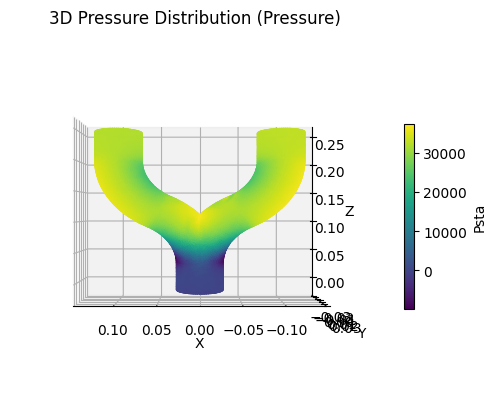

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# x, y, z, psta を想定通り取得している前提
x = data[:, 0]
y = data[:, 1]
z = data[:, 2]
psta = data[:, 6]

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x, y, z, c=psta, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Psta')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Pressure)')
ax.view_init(elev=0, azim=90)

plt.show()


In [ ]:
u_ave = data[:, 3].mean()
v_ave = data[:, 4].mean()
w_ave = data[:, 5].mean()
p_ave = data[:, 6].mean()
print(u_ave, v_ave, w_ave, p_ave)

-0.11899725 0.018432401 -99.79088 26749.492


# k3d Visualization

In [ ]:
!pip install k3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.1 MB/s eta 0:00:00


In [ ]:
import k3d
import numpy as np
from k3d.colormaps import matplotlib_color_maps
import os

# === データ準備 ===
x, y, z = data[:, 0], data[:, 1], data[:, 2]
pressure = data[:, 6]
positions = np.vstack([x, y, z]).T.astype(np.float32)
pressure_flat = pressure.flatten().astype(np.float32)

# === K3Dプロット作成 ===
plot = k3d.plot()

plt_points = k3d.points(positions=positions,
                        point_size=0.01,            # 適宜調整
                        attribute=pressure_flat,    # カラーマップの対象
                        color_map=matplotlib_color_maps.Jet,
                        opacity=0.8,                # 半透明
                        shader='3d')

plot += plt_points

# === 結果保存 ===
result_folder = './results'
os.makedirs(result_folder, exist_ok=True)

with open(result_folder + '/pressure_visualization.html', 'w') as fp:
    fp.write(plot.get_snapshot())

print('✅ 可視化HTMLを保存しました: ', result_folder + '/pressure_visualization.html')


✅ 可視化HTMLを保存しました:  ./results/pressure_visualization.html


# DeepXDE Install

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.8 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import re

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
import deepxde as dde

################ data define ####################
x_in = data[:, 0].reshape(-1, 1)
y_in = data[:, 1].reshape(-1, 1)
z_in = data[:, 2].reshape(-1, 1)
u_in = data[:, 3].reshape(-1, 1)
v_in = data[:, 4].reshape(-1, 1)
w_in = data[:, 5].reshape(-1, 1)
p_in = data[:, 6].reshape(-1, 1)

In [ ]:
# スケーリング対象列
features = ['x', 'y', 'z', 'u', 'v', 'w', 'p']
data_scaled = data.copy()
scalers = {}

# min-max scaling (x' = (x - min) / (max - min))
for i, name in enumerate(features):
    min_val = np.min(data[:, i])
    max_val = np.max(data[:, i])
    scale = max_val - min_val
    data_scaled[:, i] = (data[:, i] - min_val) / scale
    scalers[name] = {"min": min_val, "scale": scale}


In [ ]:
x_in = data_scaled[:, 0:1]
y_in = data_scaled[:, 1:2]
z_in = data_scaled[:, 2:3]
u_in = data_scaled[:, 3:4]
v_in = data_scaled[:, 4:5]
w_in = data_scaled[:, 5:6]
p_in = data_scaled[:, 6:7]

ob_xyz = np.hstack((x_in, y_in, z_in))
observe_u = dde.icbc.PointSetBC(ob_xyz, u_in, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyz, v_in, component=1)
observe_w = dde.icbc.PointSetBC(ob_xyz, w_in, component=2)
observe_p = dde.icbc.PointSetBC(ob_xyz, p_in, component=3)

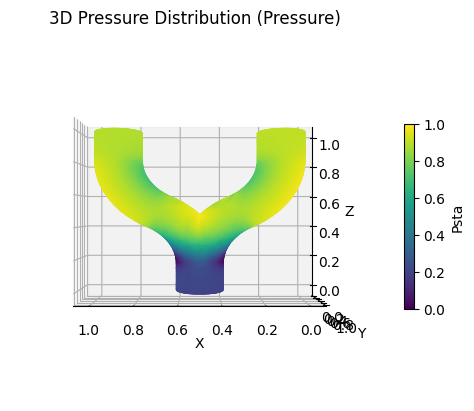

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# カラーマップ付きの3D散布図
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(x_in, y_in, z_in, c=p_in, cmap='viridis', s=1)  # pstaを色として指定

# カラーバー追加
cbar = plt.colorbar(sc, ax=ax, shrink=0.5)
cbar.set_label('Psta')

# ラベルやビュー設定
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Pressure)')
ax.view_init(elev=0, azim=90)

plt.show()

# 観測点の設定

In [ ]:
num_anchor = 10000
idx = np.random.choice(ob_xyz.shape[0], num_anchor, replace=False)
ob_xyz_sub = ob_xyz[idx]
u_in_sub = u_in[idx]
v_in_sub = v_in[idx]
w_in_sub = w_in[idx]
p_in_sub = p_in[idx]

observe_u = dde.icbc.PointSetBC(ob_xyz_sub, u_in_sub, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyz_sub, v_in_sub, component=1)
observe_w = dde.icbc.PointSetBC(ob_xyz_sub, w_in_sub, component=2)
observe_p = dde.icbc.PointSetBC(ob_xyz_sub, p_in_sub, component=3)

anchors = ob_xyz_sub

# geom 設定

In [ ]:
'''import numpy as np

xmin = np.min(ob_xyz, axis=0)
xmax = np.max(ob_xyz, axis=0)

geom = dde.geometry.Cuboid(xmin.tolist(), xmax.tolist())'''

'import numpy as np\n\nxmin = np.min(ob_xyz, axis=0)\nxmax = np.max(ob_xyz, axis=0)\n\ngeom = dde.geometry.Cuboid(xmin.tolist(), xmax.tolist())'

In [ ]:
import numpy as np
import deepxde as dde
from deepxde.geometry.geometry import Geometry
from scipy.spatial import cKDTree

class PointCloudGeometry(Geometry):
    def __init__(self, points, tol=1e-4):
        self.points = points
        self.tol = tol
        self.kdtree = cKDTree(points)

        # bbox（[min, max]）と diam（直径）を計算
        bbox = np.array([np.min(points, axis=0), np.max(points, axis=0)])
        diam = np.linalg.norm(bbox[1] - bbox[0])

        super().__init__(dim=3, bbox=bbox, diam=diam)

    def inside(self, x):
        dist, _ = self.kdtree.query(x, k=1)
        return dist < self.tol

    def on_boundary(self, x):
        dist, _ = self.kdtree.query(x, k=1)
        return np.logical_and(dist >= self.tol * 0.9, dist <= self.tol * 1.1)

    def random_points(self, n, random="pseudo"):
        raise NotImplementedError("Use anchors=... or PointSetBC instead.")

    def random_boundary_points(self, n, random="pseudo"):
        raise NotImplementedError("Use anchors=... or PointSetBC instead.")


In [ ]:
#from deepxde.geometry.geometry_3d import PointCloudGeo

geom = PointCloudGeometry(ob_xyz_sub, tol=1e-5)  # ob_xyz は形状上の点群（例えば5,000〜15,000点）


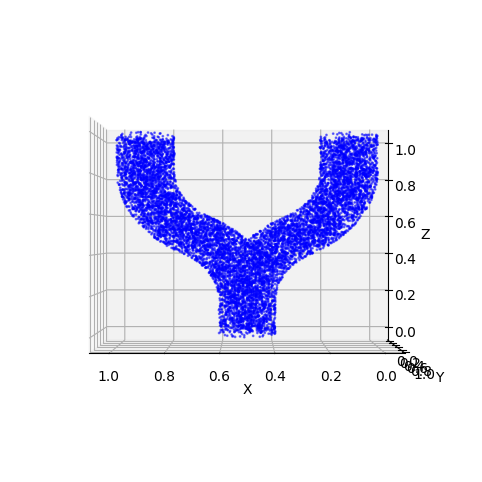

In [ ]:
# PointCloudGeometry 内の点群を取り出す
points = geom.points  # shape = (N, 3)

# x, y, z に分離
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=1, c='blue', alpha=0.5)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.view_init(elev=0, azim=90)
plt.show()


# Boundary Dirichlet 設定

In [ ]:
# z=1の境界点を抽出
mask_z1 = np.isclose(ob_xyz_sub[:, 2], 1.0, atol=1e-1)
ob_xyz_z1 = ob_xyz_sub[mask_z1]
p_z1 = np.ones((ob_xyz_z1.shape[0], 1))  # 圧力1.0

bc_z1 = dde.icbc.PointSetBC(ob_xyz_z1, p_z1, component=3)

# z=0の境界点を抽出
mask_z0 = np.isclose(ob_xyz_sub[:, 2], 0.0, atol=1e-1)
ob_xyz_z0 = ob_xyz_sub[mask_z0]
p_z0 = np.zeros((ob_xyz_z0.shape[0], 1))  # 圧力0.0

bc_z0 = dde.icbc.PointSetBC(ob_xyz_z0, p_z0, component=3)


In [ ]:
'''def boundary_z1(x, on_boundary):
    return on_boundary and np.isclose(x[:, 2], 1.0, atol=1e-1)

bc_z1 = dde.icbc.DirichletBC(geom, lambda x: 1.0, boundary_z1, component=3)

def boundary_z0(x, on_boundary):
    return on_boundary and np.isclose(x[:, 2], 0.0, atol=1e-1)

bc_z0 = dde.icbc.DirichletBC(geom, lambda x: 0.0, boundary_z0, component=3)'''


# Navier Stokes Eq 設定

In [ ]:
def Navier_Stokes_Equation_scale(x, y):
    u, v, w, p = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]

    # スケーリング係数取得
    sx, sy, sz = scalers["x"]["scale"], scalers["y"]["scale"], scalers["z"]["scale"]
    su, sv, sw, sp = scalers["u"]["scale"], scalers["v"]["scale"], scalers["w"]["scale"], scalers["p"]["scale"]

    # --- 一階微分（su/sxなどで連鎖律補正） ---
    du_dx = (su / sx) * dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = (su / sy) * dde.grad.jacobian(y, x, i=0, j=1)
    du_dz = (su / sz) * dde.grad.jacobian(y, x, i=0, j=2)

    dv_dx = (sv / sx) * dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = (sv / sy) * dde.grad.jacobian(y, x, i=1, j=1)
    dv_dz = (sv / sz) * dde.grad.jacobian(y, x, i=1, j=2)

    dw_dx = (sw / sx) * dde.grad.jacobian(y, x, i=2, j=0)
    dw_dy = (sw / sy) * dde.grad.jacobian(y, x, i=2, j=1)
    dw_dz = (sw / sz) * dde.grad.jacobian(y, x, i=2, j=2)

    dp_dx = (sp / sx) * dde.grad.jacobian(y, x, i=3, j=0)
    dp_dy = (sp / sy) * dde.grad.jacobian(y, x, i=3, j=1)
    dp_dz = (sp / sz) * dde.grad.jacobian(y, x, i=3, j=2)

    # --- 二階微分（su/sx^2などでラプラシアン項を補正） ---
    d2u_dx2 = (su / sx**2) * dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2u_dy2 = (su / sy**2) * dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2u_dz2 = (su / sz**2) * dde.grad.hessian(y, x, component=0, i=2, j=2)

    d2v_dx2 = (sv / sx**2) * dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2v_dy2 = (sv / sy**2) * dde.grad.hessian(y, x, component=1, i=1, j=1)
    d2v_dz2 = (sv / sz**2) * dde.grad.hessian(y, x, component=1, i=2, j=2)

    d2w_dx2 = (sw / sx**2) * dde.grad.hessian(y, x, component=2, i=0, j=0)
    d2w_dy2 = (sw / sy**2) * dde.grad.hessian(y, x, component=2, i=1, j=1)
    d2w_dz2 = (sw / sz**2) * dde.grad.hessian(y, x, component=2, i=2, j=2)

    # --- 物理定数（スケール済変数空間で定数値を設定） ---
    C1 = 1.0  # 質量流束のスケーリング（調整可能）
    C2 = 0.1  # 動粘性係数（相対値）

    # --- 方程式 ---
    continuity = du_dx + dv_dy + dw_dz

    x_momentum = (
        C1 * (u * du_dx + v * du_dy + w * du_dz)
        + dp_dx
        - C2 * (d2u_dx2 + d2u_dy2 + d2u_dz2)
    )

    y_momentum = (
        C1 * (u * dv_dx + v * dv_dy + w * dv_dz)
        + dp_dy
        - C2 * (d2v_dx2 + d2v_dy2 + d2v_dz2)
    )

    z_momentum = (
        C1 * (u * dw_dx + v * dw_dy + w * dw_dz)
        + dp_dz
        - C2 * (d2w_dx2 + d2w_dy2 + d2w_dz2)
    )

    return [continuity, x_momentum, y_momentum, z_momentum]


In [ ]:
'''
def Navier_Stokes_Equation_scale(x, y):
    u, v, w, p = y[:, 0:1], y[:, 1:2], y[:, 2:3], y[:, 3:4]

    # スケーリング係数取得
    sx, sy, sz = scalers["x"]["scale"], scalers["y"]["scale"], scalers["z"]["scale"]
    su, sv, sw, sp = scalers["u"]["scale"], scalers["v"]["scale"], scalers["w"]["scale"], scalers["p"]["scale"]

    # 一階微分（連鎖律スケーリング補正）
    du_dx = (1 / sx) * dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = (1 / sy) * dde.grad.jacobian(y, x, i=0, j=1)
    du_dz = (1 / sz) * dde.grad.jacobian(y, x, i=0, j=2)

    dv_dx = (1 / sx) * dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = (1 / sy) * dde.grad.jacobian(y, x, i=1, j=1)
    dv_dz = (1 / sz) * dde.grad.jacobian(y, x, i=1, j=2)

    dw_dx = (1 / sx) * dde.grad.jacobian(y, x, i=2, j=0)
    dw_dy = (1 / sy) * dde.grad.jacobian(y, x, i=2, j=1)
    dw_dz = (1 / sz) * dde.grad.jacobian(y, x, i=2, j=2)

    dp_dx = (1 / sx) * dde.grad.jacobian(y, x, i=3, j=0)
    dp_dy = (1 / sy) * dde.grad.jacobian(y, x, i=3, j=1)
    dp_dz = (1 / sz) * dde.grad.jacobian(y, x, i=3, j=2)

    # 二階微分（ラプラシアン項も連鎖律スケーリング補正）
    d2u_dx2 = (1 / sx**2) * dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2u_dy2 = (1 / sy**2) * dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2u_dz2 = (1 / sz**2) * dde.grad.hessian(y, x, component=0, i=2, j=2)

    d2v_dx2 = (1 / sx**2) * dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2v_dy2 = (1 / sy**2) * dde.grad.hessian(y, x, component=1, i=1, j=1)
    d2v_dz2 = (1 / sz**2) * dde.grad.hessian(y, x, component=1, i=2, j=2)

    d2w_dx2 = (1 / sx**2) * dde.grad.hessian(y, x, component=2, i=0, j=0)
    d2w_dy2 = (1 / sy**2) * dde.grad.hessian(y, x, component=2, i=1, j=1)
    d2w_dz2 = (1 / sz**2) * dde.grad.hessian(y, x, component=2, i=2, j=2)

    # 定数（物理量スケール補正）
    C1 = 1.0 #/ su  # 質量流束のスケーリング（適宜調整）
    C2 = 0.1       # 動粘性係数（相対値で良い場合はそのまま）

    continuity = du_dx + dv_dy + dw_dz

    x_momentum = C1 * (u * du_dx + v * du_dy + w * du_dz) + (1 / sp) * dp_dx - C2 * (d2u_dx2 + d2u_dy2 + d2u_dz2)
    y_momentum = C1 * (u * dv_dx + v * dv_dy + w * dv_dz) + (1 / sp) * dp_dy - C2 * (d2v_dx2 + d2v_dy2 + d2v_dz2)
    z_momentum = C1 * (u * dw_dx + v * dw_dy + w * dw_dz) + (1 / sp) * dp_dz - C2 * (d2w_dx2 + d2w_dy2 + d2w_dz2)

    return [continuity, x_momentum, y_momentum, z_momentum]
'''

In [ ]:
# PDEロス用の定義
'''
def Navier_Stokes_Equation(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]
    w = y[:, 2:3]
    p = y[:, 3:4]

    # 一階微分
    du_dx = dde.grad.jacobian(y, x, i=0, j=0)
    du_dy = dde.grad.jacobian(y, x, i=0, j=1)
    du_dz = dde.grad.jacobian(y, x, i=0, j=2)

    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)
    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)
    dv_dz = dde.grad.jacobian(y, x, i=1, j=2)

    dw_dx = dde.grad.jacobian(y, x, i=2, j=0)
    dw_dy = dde.grad.jacobian(y, x, i=2, j=1)
    dw_dz = dde.grad.jacobian(y, x, i=2, j=2)

    dp_dx = dde.grad.jacobian(y, x, i=3, j=0)
    dp_dy = dde.grad.jacobian(y, x, i=3, j=1)
    dp_dz = dde.grad.jacobian(y, x, i=3, j=2)

    # 二階微分（ラプラシアン項）
    d2u_dx2 = dde.grad.hessian(y, x, component=0, i=0, j=0)
    d2u_dy2 = dde.grad.hessian(y, x, component=0, i=1, j=1)
    d2u_dz2 = dde.grad.hessian(y, x, component=0, i=2, j=2)

    d2v_dx2 = dde.grad.hessian(y, x, component=1, i=0, j=0)
    d2v_dy2 = dde.grad.hessian(y, x, component=1, i=1, j=1)
    d2v_dz2 = dde.grad.hessian(y, x, component=1, i=2, j=2)

    d2w_dx2 = dde.grad.hessian(y, x, component=2, i=0, j=0)
    d2w_dy2 = dde.grad.hessian(y, x, component=2, i=1, j=1)
    d2w_dz2 = dde.grad.hessian(y, x, component=2, i=2, j=2)

    # 連続の式
    continuity = du_dx + dv_dy + dw_dz

    # 運動量保存式（定常） C1 = rho, C2 = mu
    C1=1.0
    C2=0.1
    x_momentum = C1 * (u * du_dx + v * du_dy + w * du_dz) + dp_dx - C2 * (d2u_dx2 + d2u_dy2 + d2u_dz2)
    y_momentum = C1 * (u * dv_dx + v * dv_dy + w * dv_dz) + dp_dy - C2 * (d2v_dx2 + d2v_dy2 + d2v_dz2)
    z_momentum = C1 * (u * dw_dx + v * dw_dy + w * dw_dz) + dp_dz - C2 * (d2w_dx2 + d2w_dy2 + d2w_dz2)

    return [continuity, x_momentum, y_momentum, z_momentum]
'''

'\ndef Navier_Stokes_Equation(x, y):\n    u = y[:, 0:1]\n    v = y[:, 1:2]\n    w = y[:, 2:3]\n    p = y[:, 3:4]\n\n    # 一階微分\n    du_dx = dde.grad.jacobian(y, x, i=0, j=0)\n    du_dy = dde.grad.jacobian(y, x, i=0, j=1)\n    du_dz = dde.grad.jacobian(y, x, i=0, j=2)\n\n    dv_dx = dde.grad.jacobian(y, x, i=1, j=0)\n    dv_dy = dde.grad.jacobian(y, x, i=1, j=1)\n    dv_dz = dde.grad.jacobian(y, x, i=1, j=2)\n\n    dw_dx = dde.grad.jacobian(y, x, i=2, j=0)\n    dw_dy = dde.grad.jacobian(y, x, i=2, j=1)\n    dw_dz = dde.grad.jacobian(y, x, i=2, j=2)\n\n    dp_dx = dde.grad.jacobian(y, x, i=3, j=0)\n    dp_dy = dde.grad.jacobian(y, x, i=3, j=1)\n    dp_dz = dde.grad.jacobian(y, x, i=3, j=2)\n\n    # 二階微分（ラプラシアン項）\n    d2u_dx2 = dde.grad.hessian(y, x, component=0, i=0, j=0)\n    d2u_dy2 = dde.grad.hessian(y, x, component=0, i=1, j=1)\n    d2u_dz2 = dde.grad.hessian(y, x, component=0, i=2, j=2)\n\n    d2v_dx2 = dde.grad.hessian(y, x, component=1, i=0, j=0)\n    d2v_dy2 = dde.grad.hessian(y,

In [ ]:
# definet the DNN
layer_size = [3] + [50] *8 + [4]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [ ]:
data = dde.data.PDE(
    geom,
    Navier_Stokes_Equation_scale,
    [observe_u, observe_v, observe_w, observe_p, bc_z0, bc_z1],
    #num_domain=1000,
    #num_boundary=1000,
    anchors = ob_xyz_sub
)

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=1e-3, loss_weights=[1e-3,1e-6,1e-6,1e-6, 1,1,1,1, 10,10])
losshistory, train_state = model.train(
    iterations=10000,
    callbacks=[],
    display_every=1000,
    disregard_previous_best=True
)

Compiling model...
'compile' took 5.945035 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [3.73e+01, 3.14e+02, 1.19e+04, 9.50e+02, 6.70e-01, 1.41e-01, 2.55e-01, 4.46e-01, 3.83e-02, 6.41e+00]    [3.73e+01, 3.14e+02, 1.19e+04, 9.50e+02, 6.70e-01, 1.41e-01, 2.55e-01, 4.46e-01, 3.83e-02, 6.41e+00]    []  


KeyboardInterrupt: 

In [ ]:
# ✅ 重みを保存
model.save("model_weights.ckpt")  # 任意のファイル名

'model_weights.ckpt-10000.ckpt'

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


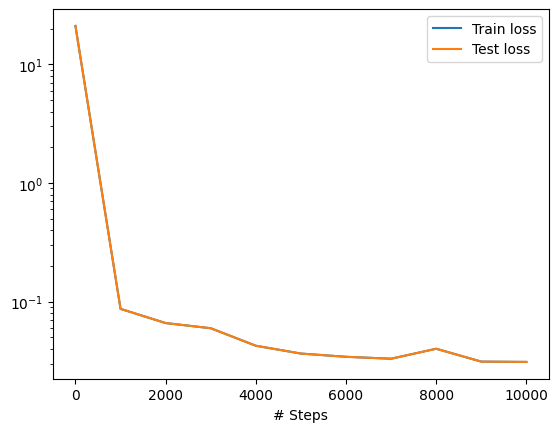

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
# Evaluation
eval_points = geom.uniform_points(500000)

f = model.predict(eval_points, operator=Navier_Stokes_Equation_scale)

x_pre = eval_points[:, 0]
y_pre = eval_points[:, 1]
z_pre = eval_points[:, 2]
p_pre = f[3]


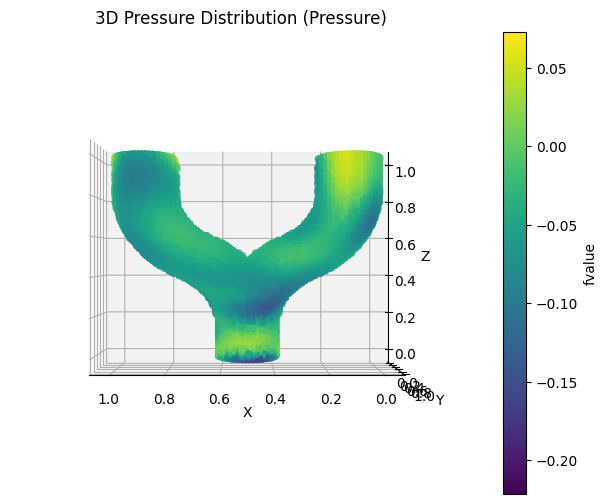

In [ ]:
from sklearn.neighbors import KDTree
import numpy as np

all_points = np.stack([x_pre, y_pre, z_pre], axis=1)
tree = KDTree(ob_xyz)
dist, _ = tree.query(all_points, k=1)
mask = dist.flatten() < 0.01

x_vis = x_pre[mask]
y_vis = y_pre[mask]
z_vis = z_pre[mask]
p_vis = p_pre[mask]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_vis, y_vis, z_vis, c=p_vis, cmap='viridis', marker='o')
plt.colorbar(sc, ax=ax, label='fvalue')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Pressure Distribution (Pressure)')
ax.view_init(elev=0, azim=90)
plt.show()

In [ ]:
# BCを定義　たとえば入り口の圧力をMaxで設定するなど

In [ ]:
# MSEを取るCAEデータとの模倣学習
'''
observe_u = dde.icbc.PointSetBC(ob_xyt, ob_u, component=0)
observe_v = dde.icbc.PointSetBC(ob_xyt, ob_v, component=1)
observe_w = dde.icbc.PointSetBC(ob_xyt, ob_v, component=2)
observe_p = dde.icbc.PointSetBC(ob_xyt, ob_p, component=3)
'''